In [3]:
import json
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import numpy as np

In [6]:
with open('/content/DeteksiSarkasme.json', 'r') as file:
    data = [json.loads(line) for line in file]

In [7]:
df_tf = pd.DataFrame(data)[['headline', 'is_sarcastic']]

In [8]:
tokenizer_tf = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer_tf.fit_on_texts(df_tf['headline'])

sequences_tf = tokenizer_tf.texts_to_sequences(df_tf['headline'])
padded_tf = pad_sequences(sequences_tf, maxlen=40, padding='post', truncating='post')

In [9]:
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(padded_tf, df_tf['is_sarcastic'], test_size=0.2, random_state=42)

In [10]:
# Hitung class weight untuk menangani imbalance
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_tf),
    y=y_train_tf
)

class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class Weights:", class_weights_dict)

Class Weights: {0: np.float64(0.8911085161397948), 1: np.float64(1.1392087865216465)}


In [11]:
# GRU Model dengan kapasitas lebih besar
model_tf = tf.keras.Sequential([
    tf.keras.layers.Embedding(10000, 128),
    tf.keras.layers.GRU(128, dropout=0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_tf.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Build model supaya bisa tampil summary
model_tf.build(input_shape=(None, 40))
model_tf.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 40, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 128)            │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,387,393 (5.29 MB)

 Trainable params: 1,387,393 (5.29 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
history_tf = model_tf.fit(
    X_train_tf, y_train_tf,
    epochs=20,
    batch_size=64,
    validation_data=(X_test_tf, y_test_tf),
    class_weight=class_weights_dict
)

Epoch 1/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 61s 174ms/step - accuracy: 0.4955 - loss: 0.6942 - val_accuracy: 0.4392 - val_loss: 0.6950
Epoch 2/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 68s 132ms/step - accuracy: 0.5001 - loss: 0.6927 - val_accuracy: 0.4392 - val_loss: 0.6940
Epoch 3/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 79s 122ms/step - accuracy: 0.4445 - loss: 0.6933 - val_accuracy: 0.5608 - val_loss: 0.6925
Epoch 4/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 40s 119ms/step - accuracy: 0.5267 - loss: 0.6926 - val_accuracy: 0.4392 - val_loss: 0.6951
Epoch 5/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 42s 123ms/step - accuracy: 0.4894 - loss: 0.6934 - val_accuracy: 0.4392 - val_loss: 0.6938
Epoch 6/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 81s 120ms/step - accuracy: 0.4940 - loss: 0.6939 - val_accuracy: 0.5608 - val_loss: 0.6929
Epoch 7/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 41s 123ms/step - accuracy: 0.4737 - loss: 0.6938 - val_accuracy: 0.5608 - val_loss: 0.6931
Epoch 8/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 82s 123ms/step - accuracy: 0.5516 - loss: 0

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Prediksi probabilitas
y_pred_prob_tf = model_tf.predict(X_test_tf)
# Konversi ke label 0/1
y_pred_tf = (y_pred_prob_tf > 0.5).astype(int)

# Evaluasi
acc = accuracy_score(y_test_tf, y_pred_tf)
prec = precision_score(y_test_tf, y_pred_tf)
rec = recall_score(y_test_tf, y_pred_tf)
f1 = f1_score(y_test_tf, y_pred_tf)
auc = roc_auc_score(y_test_tf, y_pred_prob_tf)

print(f"Akurasi: {acc:.4f}")
print(f"Presisi: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
Akurasi: 0.5608
Presisi: 0.0000
Recall: 0.0000
F1-Score: 0.0000
AUC: 0.5071


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


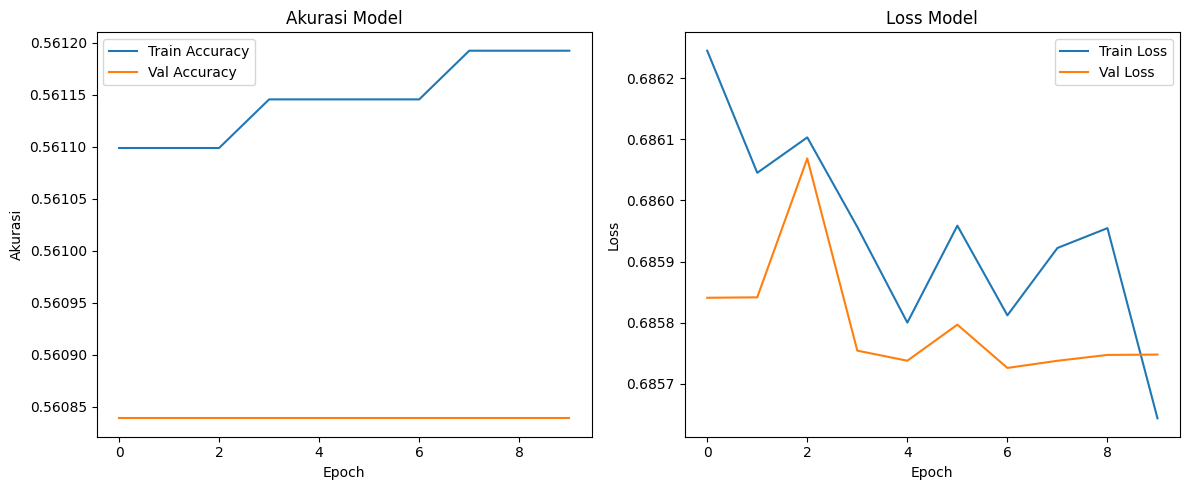

In [10]:
plt.figure(figsize=(12,5))

# Akurasi
plt.subplot(1,2,1)
plt.plot(history_tf.history['accuracy'], label='Train Accuracy')
plt.plot(history_tf.history['val_accuracy'], label='Val Accuracy')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_tf.history['loss'], label='Train Loss')
plt.plot(history_tf.history['val_loss'], label='Val Loss')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

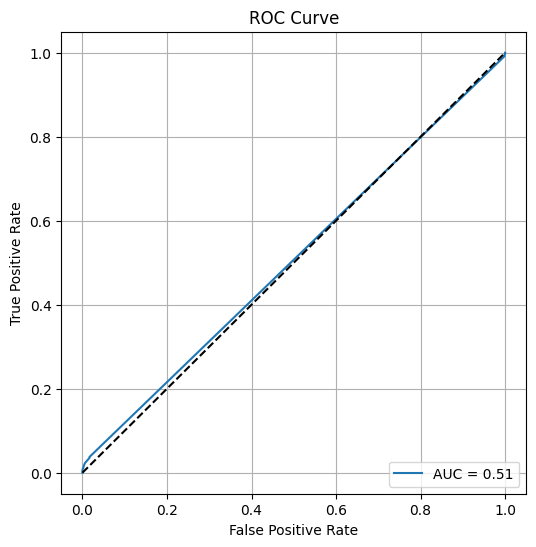

In [11]:
fpr, tpr, thresholds = roc_curve(y_test_tf, y_pred_prob_tf)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [12]:
sequences_pt = tokenizer_tf.texts_to_sequences(df_tf['headline'])
padded_pt = pad_sequences(sequences_pt, maxlen=40, padding='post', truncating='post')
labels_pt = df_tf['is_sarcastic'].values

In [13]:
X_train_pt, X_test_pt, y_train_pt, y_test_pt = train_test_split(
    padded_pt, labels_pt, test_size=0.2, random_state=42)

In [14]:
class SarcasmDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = torch.tensor(texts, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

train_ds_pt = SarcasmDataset(X_train_pt, y_train_pt)
test_ds_pt = SarcasmDataset(X_test_pt, y_test_pt)

train_loader_pt = DataLoader(train_ds_pt, batch_size=64, shuffle=True)
test_loader_pt = DataLoader(test_ds_pt, batch_size=64, shuffle=False)

In [15]:
class GRUModelPT(nn.Module):
    def __init__(self, vocab_size=10000, embed_dim=128, hidden_dim=128):
        super(GRUModelPT, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, 64)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.embedding(x)
        _, h_n = self.gru(x)
        x = F.relu(self.fc1(h_n.squeeze(0)))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_pt = GRUModelPT().to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model_pt.parameters(), lr=0.001)

# Untuk visualisasi
train_loss_hist = []
val_loss_hist = []

# Training
for epoch in range(1, 11):  # 10 epoch
    model_pt.train()
    total_loss = 0
    for inputs, targets in train_loader_pt:
        inputs, targets = inputs.to(device), targets.to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model_pt(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    train_loss_hist.append(total_loss / len(train_loader_pt))

    # Validation Loss
    model_pt.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader_pt:
            inputs, targets = inputs.to(device), targets.to(device).unsqueeze(1)
            outputs = model_pt(inputs)
            loss = loss_fn(outputs, targets)
            val_loss += loss.item()
    val_loss_hist.append(val_loss / len(test_loader_pt))

    print(f"Epoch {epoch}, Train Loss: {train_loss_hist[-1]:.4f}, Val Loss: {val_loss_hist[-1]:.4f}")

Epoch 1, Train Loss: 0.6043, Val Loss: 0.4622
Epoch 2, Train Loss: 0.3860, Val Loss: 0.3796
Epoch 3, Train Loss: 0.2693, Val Loss: 0.3748
Epoch 4, Train Loss: 0.1820, Val Loss: 0.4036
Epoch 5, Train Loss: 0.1086, Val Loss: 0.4775
Epoch 6, Train Loss: 0.0620, Val Loss: 0.6389
Epoch 7, Train Loss: 0.0372, Val Loss: 0.6976
Epoch 8, Train Loss: 0.0303, Val Loss: 0.6983
Epoch 9, Train Loss: 0.0188, Val Loss: 0.8042
Epoch 10, Train Loss: 0.0129, Val Loss: 0.8873


In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

# Prediksi
model_pt.eval()
all_preds = []
all_probs = []
all_targets = []

with torch.no_grad():
    for inputs, targets in test_loader_pt:
        inputs = inputs.to(device)
        outputs = model_pt(inputs)
        probs = outputs.cpu().numpy()
        preds = (probs > 0.5).astype(int)
        all_preds.extend(preds)
        all_probs.extend(probs)
        all_targets.extend(targets.numpy())

# Evaluasi
print("Akurasi:", accuracy_score(all_targets, all_preds))
print("Presisi:", precision_score(all_targets, all_preds, zero_division=0))
print("Recall:", recall_score(all_targets, all_preds, zero_division=0))
print("F1-Score:", f1_score(all_targets, all_preds, zero_division=0))
print("AUC:", roc_auc_score(all_targets, all_probs))

Akurasi: 0.8403219767877199
Presisi: 0.8159119763013118
Recall: 0.8218243819266837
F1-Score: 0.8188575069016777
AUC: 0.9170346623005153


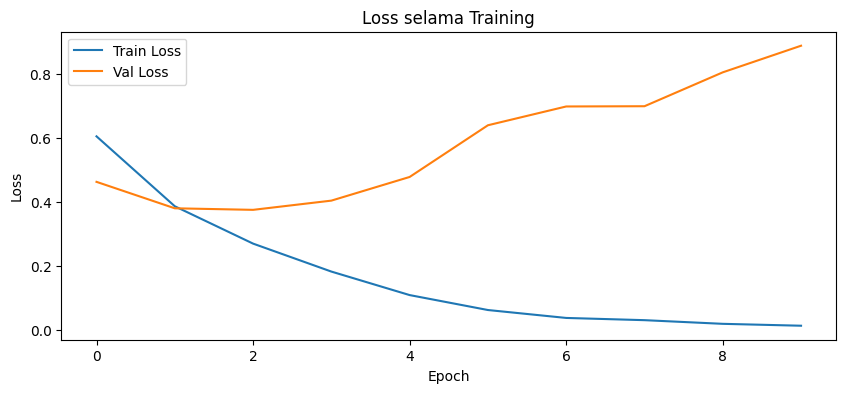

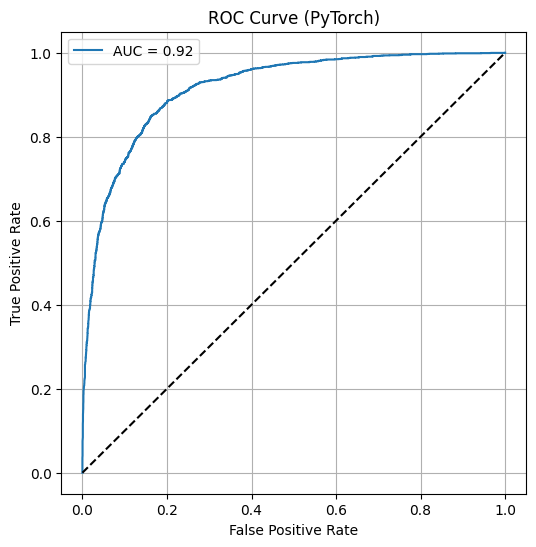

In [18]:
import matplotlib.pyplot as plt

# Loss Plot
plt.figure(figsize=(10, 4))
plt.plot(train_loss_hist, label='Train Loss')
plt.plot(val_loss_hist, label='Val Loss')
plt.title("Loss selama Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# ROC Curve
fpr_pt, tpr_pt, _ = roc_curve(all_targets, all_probs)
plt.figure(figsize=(6,6))
plt.plot(fpr_pt, tpr_pt, label=f"AUC = {roc_auc_score(all_targets, all_probs):.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (PyTorch)')
plt.legend()
plt.grid()
plt.show()

In [19]:
!pip install -q -U keras-tuner

import keras_tuner as kt
from tensorflow import keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.3 MB/s eta 0:00:00


In [20]:
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Embedding(
        input_dim=10000,
        output_dim=hp.Int("embed_dim", min_value=64, max_value=256, step=64)
    ))
    model.add(keras.layers.GRU(
        units=hp.Int("gru_units", min_value=64, max_value=256, step=64),
        dropout=hp.Float("dropout", min_value=0.1, max_value=0.5, step=0.1)
    ))
    model.add(keras.layers.Dense(
        units=hp.Int("dense_units", min_value=32, max_value=128, step=32),
        activation="relu"
    ))
    model.add(keras.layers.Dense(1, activation="sigmoid"))

    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")
        ),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [21]:
# Setup Tuner (pakai RandomSearch biar cepat)
tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=5,       # bisa ditambah untuk eksplorasi lebih banyak
    executions_per_trial=1,
    directory="sarcasm_gru_tuning",
    project_name="gru_tuner"
)

# Callback untuk early stopping
early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)

# Jalankan pencarian
tuner.search(
    X_train_tf, y_train_tf,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    class_weight=class_weights_dict
)

Trial 5 Complete [00h 05m 13s]
val_accuracy: 0.5538137555122375

Best val_accuracy So Far: 0.8514272570610046
Total elapsed time: 00h 28m 47s


In [22]:
best_model = tuner.get_best_models(num_models=1)[0]

# Latih ulang pada data training & validasi
history_best = best_model.fit(
    X_train_tf, y_train_tf,
    epochs=15,
    batch_size=64,
    validation_data=(X_test_tf, y_test_tf),
    callbacks=[early_stop],
    class_weight=class_weights_dict
)

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


334/334 ━━━━━━━━━━━━━━━━━━━━ 81s 224ms/step - accuracy: 0.9063 - loss: 0.2225 - val_accuracy: 0.8536 - val_loss: 0.3682
Epoch 2/15
334/334 ━━━━━━━━━━━━━━━━━━━━ 74s 222ms/step - accuracy: 0.9328 - loss: 0.1691 - val_accuracy: 0.8553 - val_loss: 0.4427
Epoch 3/15
334/334 ━━━━━━━━━━━━━━━━━━━━ 81s 219ms/step - accuracy: 0.9513 - loss: 0.1241 - val_accuracy: 0.8489 - val_loss: 0.4991
Epoch 4/15
334/334 ━━━━━━━━━━━━━━━━━━━━ 73s 217ms/step - accuracy: 0.9608 - loss: 0.1056 - val_accuracy: 0.8418 - val_loss: 0.5454


In [23]:
y_pred_prob_best = best_model.predict(X_test_tf)
y_pred_best = (y_pred_prob_best > 0.5).astype(int)

print("Akurasi:", accuracy_score(y_test_tf, y_pred_best))
print("Presisi:", precision_score(y_test_tf, y_pred_best, zero_division=0))
print("Recall:", recall_score(y_test_tf, y_pred_best, zero_division=0))
print("F1-Score:", f1_score(y_test_tf, y_pred_best, zero_division=0))
print("AUC:", roc_auc_score(y_test_tf, y_pred_prob_best))

167/167 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step
Akurasi: 0.8418195432422314
Presisi: 0.8348951360999554
Recall: 0.7975277067348678
F1-Score: 0.815783736647046
AUC: 0.9178243625772129


In [24]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
for param in best_hps.values:
    print(f"{param}: {best_hps.get(param)}")

Best Hyperparameters:
embed_dim: 64
gru_units: 256
dropout: 0.4
dense_units: 96
learning_rate: 0.008713761456731816


In [26]:
train_acc = history_best.history['accuracy'][-1]
val_acc = history_best.history['val_accuracy'][-1]

print(f"Akurasi Akhir (Training): {train_acc:.4f}")
print(f"Akurasi Akhir (Testing / Validation): {val_acc:.4f}")

loss, test_acc = best_model.evaluate(X_test_tf, y_test_tf, verbose=0)
print(f"Akurasi Evaluasi Langsung (X_test vs y_test): {test_acc:.4f}")

Akurasi Akhir (Training): 0.9531
Akurasi Akhir (Testing / Validation): 0.8418
Akurasi Evaluasi Langsung (X_test vs y_test): 0.8418
